# Quando finirà il Coronavirus🦠?

## **Analisi dell'andamento** del **Coronavirus** in Italia🌍 

I dati🔢 provengono dalla repository ufficiale della Protezione Civile italiana e vengono aggiornati ogni giorno. https://github.com/pcm-dpc/COVID-19

Costruito con Python e Jupyter Notebook

In [43]:
import pandas as pd
import numpy as np
from datetime import timedelta
from datetime import datetime
from sklearn.metrics import mean_squared_error
from scipy.optimize import curve_fit
from scipy.optimize import fsolve
import matplotlib.pyplot as plt

%matplotlib inline

## Recupero degli ultimi dati

In [44]:
data = pd.read_json(
    "https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-json/dpc-covid19-ita-andamento-nazionale.json"
)

In [45]:
data = data.loc[:, ["data", "totale_casi"]]
FMT = "%Y-%m-%dT%H:%M:%S"
data["data"] = data["data"].map(
    lambda x: (
        datetime.strptime(x, FMT) - datetime.strptime("2020-01-01T00:00:00", FMT)
    ).days
)
print("Dati degli ultimi sette giorni📅")
data[-7:]

Dati degli ultimi sette giorni📅


,data,totale_casi
77,131,219814
78,132,221216
79,133,222104
80,134,223096
81,135,223885
82,136,224760
83,137,225435


## Calcolo funzione logistica

### La funzione utilizzata è una funzione sigmoidale
$$f(x; a, b, c) = \frac{c}{1 + e ^ -\dfrac{x - b}{a}}$$

**Vengono passati tre parametri:**
- **a**: Velocità dell'infezione (inizialmente 1)
- **b**: Il giorno del massimo delle infezioni
- **c**: Il numero totale di persone infette

La funzione è ricorsiva, ovvero richiama se stessa all'infinito fino a quando non si raggiunge un valore minimo -nel nostro caso 0, che corrisponde al totale appiattimento della curva.

In [46]:
def logistic_model(x, a, b, c):
    return c / (1 + np.exp(-(x - b) / a))

In [47]:
x = list(data.iloc[:, 0])
y = list(data.iloc[:, 1])
fit = curve_fit(logistic_model, x, y, p0=[1, max(x), max(y)])

speed, x_peak, y_max = fit[0]

### Trovo il picco

Dalla funzione logistica sono stati ricavati tre vettori che rappresentano l'andamento della curva giorno per giorno: 
- Velocità di crescita (speed)
- Punto di massimo sull'asse X (x_peak)
- Punto di massimo sull'asse Y (y_peak)

Con questi valori è possibile calcolare il punto della fine dell'epidemia. Per farlo viene inserito il punto x nella funzione e si ricava y. 
Per farlo si utilizza la funzione **fsolve** (trova le radici di una funzione non lineare) la quale prende come parametri la funzione (nel nostro caso la curva) e un punto di massimo sull'asse x. 

In [48]:
end = int(
    fsolve(lambda x: logistic_model(x, speed, x_peak, y_max) - int(y_max), x_peak)
)
end

249

### Grafico

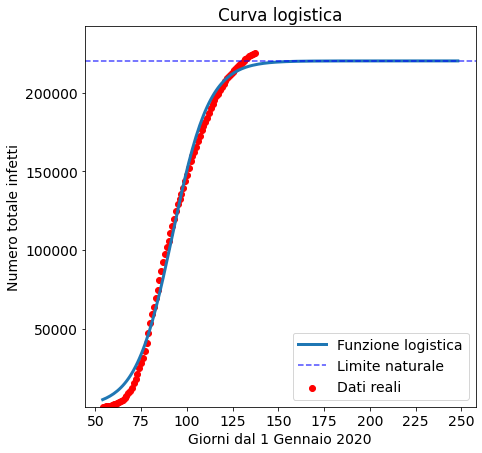

In [49]:
pred_x = list(range(max(x), end))

def plot_curve(x_axis, logistic_data):
    plt.rcParams["figure.figsize"] = [7, 7]
    plt.rc("font", size=14)
    # Real data
    plt.scatter(x, y, label="Dati reali", color="red")
    # Predicted logistic curve
    plt.plot(
        x_axis,
        logistic_data,
        linewidth=3,
        label="Funzione logistica",
    )
    plt.axhline(
        y=max(logistic_data),
        color="blue",
        linestyle="dashed",
        alpha=0.7,
        linewidth=1.5,
        label="Limite naturale",
    )

    plt.legend()
    plt.xlabel("Giorni dal 1 Gennaio 2020")
    plt.ylabel("Numero totale infetti")
    plt.title("Curva logistica")
    plt.ylim((min(y) * 0.9, y_max * 1.1))
    plt.show()


plot_curve(x + pred_x, [logistic_model(i, fit[0][0], fit[0][1], fit[0][2]) for i in x + pred_x])

È possibile osservare che la curva è formata da due rami: uno esponenziale (parte bassa) e uno logaritmico (parte alta). 
Il cambio di concavità avviene in centro nel punto di flesso.


## Tasso di crescita

### Calcolo

In [50]:
data["differenza_giorno_precedente"] = data.diff()["totale_casi"]
data["tasso_crescita"] = round(
    data["differenza_giorno_precedente"]
    / (data["totale_casi"] - data["differenza_giorno_precedente"])
    * 100,
    1,
)
data["tasso_crescita"].fillna(0)
data["data"].fillna(0)
data[-7:]

,data,totale_casi,differenza_giorno_precedente,tasso_crescita
77,131,219814,744.0,0.3
78,132,221216,1402.0,0.6
79,133,222104,888.0,0.4
80,134,223096,992.0,0.4
81,135,223885,789.0,0.4
82,136,224760,875.0,0.4
83,137,225435,675.0,0.3


### Aggiornamento dataframe con i dati ottenuti dalla funzione logistica

In [51]:
d = {
    "data": x + pred_x,
    "totale_casi": [
        logistic_model(i, fit[0][0], fit[0][1], fit[0][2]) for i in x + pred_x
    ],
}
df = pd.DataFrame(data=d)
df["differenza_giorno_precedente"] = df.diff()["totale_casi"]
df["tasso_crescita"] = round(
    df["differenza_giorno_precedente"]
    / (df["totale_casi"] - df["differenza_giorno_precedente"])
    * 100,
    1,
)
merge = pd.concat([data, df[df.data > max(data["data"])]])

In [52]:
def get_day(day):
    return datetime.strptime("2020-1-1", "%Y-%m-%d") + timedelta(days=int(round(day)))

### Grafico

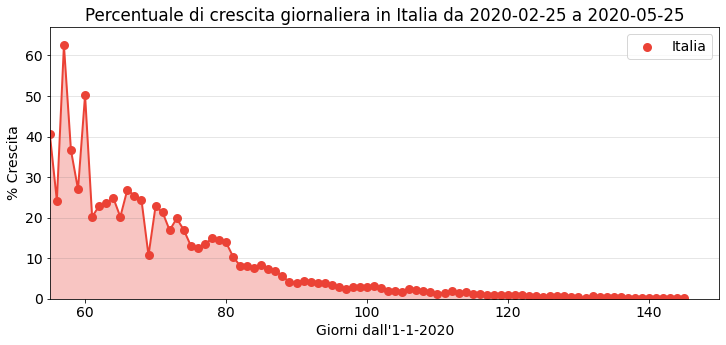

In [53]:
def infection_grow(x, y):
    plt.rc("font", size=14)
    plt.figure(figsize=(12, 5))
    plt_axes = plt.gca()
    plt_axes.grid(axis="y", color=(0.4, 0.4, 0.4), alpha=0.2)
    plt.stackplot(x, y, color=(0.92, 0.26, 0.21, 0.3), linewidth=0)
    plt.plot(x, y, color=(0.92, 0.26, 0.21), linewidth=2)
    plt.scatter(x, y, color=(0.92, 0.26, 0.21), label="Italia", linewidth=3)
    plt.xlim(int(min(x)), int(max(x) + 5))
    plt.ylim(int(min(y)), int(max(y)) + 5)
    plt.title(
        "Percentuale di crescita giornaliera in Italia da "
        + str(get_day(min(x)).date())
        + " a "
        + str(get_day(max(x)).date())
    )
    plt.xlabel("Giorni dall'1-1-2020")
    plt.ylabel("% Crescita")
    plt.legend()
    plt.show()


infection_grow(
    merge[merge.tasso_crescita > 0]["data"].values.tolist(),
    merge[merge.tasso_crescita > 0]["tasso_crescita"].values.tolist(),
)

## Quando raggiungeremo la fine?

In [54]:
end_date = datetime.strptime("2020-1-1", "%Y-%m-%d") + timedelta(days=end)
months = [
    "gennaio",
    "febbraio",
    "marzo",
    "aprile",
    "maggio",
    "giugno",
    "luglio",
    "agosto",
    "settembre",
    "ottobre",
    "novembre",
    "dicembre",
]
print(
    "L'epidemia finirà in data "
    + str(end_date.day)
    + " "
    + months[end_date.month - 1]
    + " "
    + str(end_date.year)
)
print("Il numero dei contagiati sarà di " + str(int(round(y_max))))

print(
    "Il picco è stato il "
    + str(get_day(x_peak).day)
    + " "
    + months[get_day(x_peak).month - 1]
    + " "
    + str(get_day(x_peak).year)
)

L'epidemia finirà in data 6 settembre 2020
Il numero dei contagiati sarà di 220183
Il picco è stato il 2 aprile 2020


### Osservazioni
La curva non rappresenta fedelmente la realtà a causa delle caratteristiche della malattia, che la rendono difficilmente individuabile prima della comparsa dei primi sintomi: molte persone sono portatori asintomatici.   
A ciò, si aggiunge l'impossibilità di fare un censimento dei contagi su tutta la popolazione, perché cambiando il criterio tutti i dati verrebbero alterati.

Altro problema che rende la curva distaccata dalla realtà, sono i dati dei primi giorni. Il primo caso è stato registrato a Codogno, ma la malattia potrebbe essere stata presente in altre zone qualche settimana prima, e ciò spiegherebbe la veloce diffusione nella prima fase.

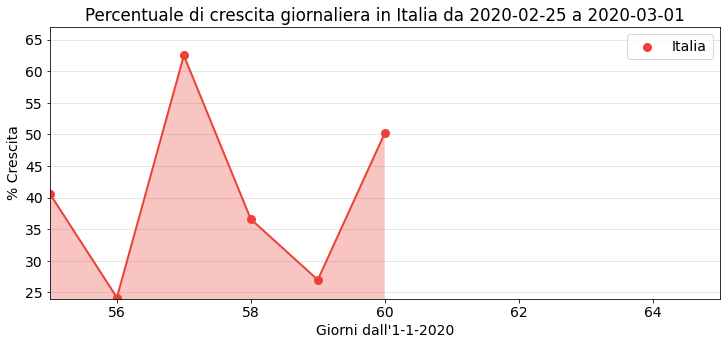

In [41]:
infection_grow(
    data[1:7]["data"].values.tolist(),
    data[1:7]["tasso_crescita"].values.tolist(),
)

#### Report Aprile
Osservando i dati degli ultimi giorni sembra che ci stiamo avvicinando all'asintoto della resistenza ambientale. Tuttavia non significa che siamo alla fine dell'isolamento, in quanto se le persone tornassero a circolare improvvisamente potrebbe esserci una ripresa dell'epidemia.

#### Report da 4 a 17 Maggio
Di recente è iniziata la fase 2, dove le misure del lockdown sono state allentate. Neglle ultime settimane il tasso di crescita è rimasto sotto l'1%.
Ciò è un buon segnale, ma dovremo aspettare ancora questa settimana per confermare l'andamento.

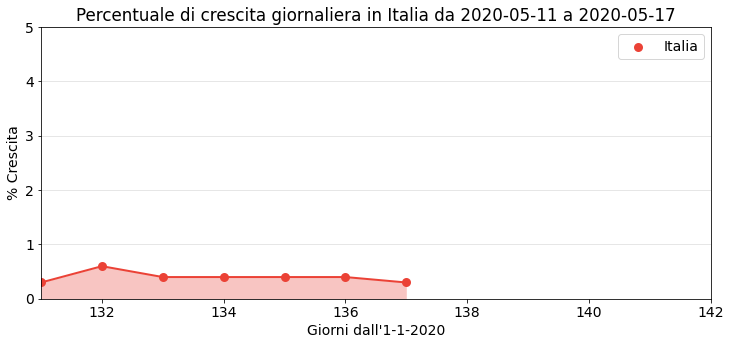

Dati


In [42]:
infection_grow(
    data[-7:84]["data"].values.tolist(),
    data[-7:84]["tasso_crescita"].values.tolist(),
)
print("Dati")